In [1]:
from numpy import int8
def to_dummy(x, out='all'):
    """Convert nums to dummies"""
    index = x.index
    heroes = [name for name in x.columns.values if '_hero' in name]
    xh = x[heroes]
    #xl = x['lobby_type']
    max_hero = xh.values.max()
    xn = x.drop(heroes, axis=1)
    #xn.drop('lobby_type', axis=1, inplace=True)
    xh_team = pd.get_dummies(xh, columns=heroes)
    #xl_dummy = pd.get_dummies(xl).values
    x_radiant = pd.DataFrame(index=index)
    x_dire = pd.DataFrame(index=index)
    for person in range(1, max_hero + 1):
        dire = zeros((xn.shape[0]), dtype=int8)
        radiant = zeros((xn.shape[0]), dtype=int8)
        for num_team in range(1, 6):
            try:
                dire += xh_team[f'd{num_team}_hero_{person}'].values
            except:
                pass
            try:
                radiant += xh_team[f'r{num_team}_hero_{person}'].values
            except:
                pass
        try:
            x_radiant[f'{person}'] = radiant
        except:
            pass
        try:
            x_dire[f'{person}'] = dire
        except:
            pass
    if out == 'all':
        return np.concatenate([x_radiant - x_dire, xn], axis=1)#xl_dummy, 
    elif out == 'radiant':
        return np.concatenate([x_radiant, xn], axis=1)#, xl_dummy
    elif out == "dire":
        return np.concatenate([x_dire, xn], axis=1)#, xl_dummy



In [12]:
import pandas as pd
from pandas import DataFrame
import numpy as np
from numpy import array, zeros
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, make_scorer, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from math import exp
import time
import datetime
%matplotlib  inline
warnings.simplefilter('ignore')

## Подход 1: градиентный бустинг "в лоб"

В отчете по данному этапу необходимо ответить на следующие вопросы:
1. Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?
2. Как называется столбец, содержащий целевую переменную?
3. Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Инструкцию по измерению времени можно найти ниже по тексту. Какое качество при этом получилось? Напомним, что в данном задании мы используем метрику качества AUC-ROC.
4. Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?

Загружаем файл с данными о матчах...

In [3]:
Xcsv = pd.read_csv('out_featers.csv', index_col='match_id')

... и проверяем какие признаки содержат пропущенные данные

In [4]:
rows = Xcsv.shape[0]
for col in Xcsv.columns:
    if Xcsv[col].count() < rows:
        print(f'Признак {col} содержит {rows - Xcsv[col].count()} пропущенных значений')
        

Признак first_blood_time содержит 14736 пропущенных значений
Признак first_blood_team содержит 14736 пропущенных значений
Признак first_blood_player1 содержит 14736 пропущенных значений
Признак first_blood_player2 содержит 41135 пропущенных значений
Признак radiant_bottle_time содержит 15691 пропущенных значений
Признак radiant_courier_time содержит 692 пропущенных значений
Признак radiant_flying_courier_time содержит 27479 пропущенных значений
Признак radiant_first_ward_time содержит 1836 пропущенных значений
Признак dire_bottle_time содержит 16143 пропущенных значений
Признак dire_courier_time содержит 676 пропущенных значений
Признак dire_flying_courier_time содержит 26098 пропущенных значений
Признак dire_first_ward_time содержит 1826 пропущенных значений


Большинство признаков с пропущенными значениями относятся к временным меткам и означают, что за первые пять минут матча соответствующее событие не произошло. В задании рекомендуется заменить такие значения на 0, но такая рекомендация в данном случае не вполне подходит. Правильнее было бы заменить эти значения, на время превосходящее или равное пяти минутам. Пропущенные значения first_blood_player1 и first_blood_player2 заменим на медианные значения по признаку. Затем проверим, что у нас больше не осталось пропущенных данных.

<b>Целевая переменная содержится в столбце 'radiant_win'.</b> Создадим из него объект ответов Y и удалим из обучающей выборки. Удалим из выборки признаки, связанные с итогами матча.

In [5]:
X = Xcsv[::]
X['first_blood_player1'].fillna(X['first_blood_player1'].median(), inplace=True)
X['first_blood_player2'].fillna(X['first_blood_player2'].median(), inplace=True)
X.fillna(0, inplace=True)
Y = X['radiant_win']
X.drop(['radiant_win',
        'duration',
        'tower_status_radiant', 
        'tower_status_dire', 
        'barracks_status_dire', 
        'barracks_status_radiant', 
        'start_time'],
       axis=1, inplace=True)
rows = X.shape[0]
for col in X.columns:
    if X[col].count() < rows:
        print(f'Признак {col} содержит {rows - Xcsv[col].count()} пропущенных значений')
print(f'Xcsv.shape is {Xcsv.shape}')
print(f'X.shape is {X.shape}')

Xcsv.shape is (97230, 108)
X.shape is (97230, 101)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f01d9921898>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f01d8b6f5c0>]], dtype=object)

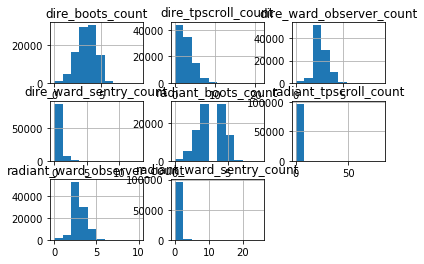

In [13]:
X[[col for col in X.columns if 'count' in col]].hist();

Проведём сначала решётчатый поиск на градиентном бустинге для определения оптимальных параметров. 

In [6]:
params = {
         'learning_rate': [i/20 for i in range(4, 11)],
         'max_depth':[i for i in range(2, 5)]}
print(*params.items(), sep='\n')

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size = 0.3,
    random_state = 241 )

cv = KFold(n_splits=5, shuffle=True, random_state=241)
scorer = make_scorer(roc_auc_score)
#'n_estimators':[10*i for i in range(1, 6)],

('learning_rate', [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
('max_depth', [2, 3, 4])


grid = GridSearchCV(GradientBoostingClassifier(random_state=241),
                    params, cv=cv, n_jobs=-1, scoring=scorer, verbose=True)
grid.fit(X_train, Y_train)

Проведём кросс-валидацию на полной выборке с наилучшими значениями <i>'learning_rate'</i> и <i>'max_depth'</i>, полученными в предыдущем пункте с количеством деревьев равным 30. Измерим время кросс-валидации.

print(f"""Наилучшие значения параметров:
"""grid.best_params_

clf = GradientBoostingClassifier(
    learning_rate=grid.best_params_['learning_rate'],
    max_depth=grid.best_params_['max_depth'],
    n_estimators=30,
    random_state=241, verbose=False )
%time crossval_scores = cross_val_score(clf, X, Y, cv=cv, scoring=scorer)
for i, cscore in enumerate(crossval_scores):
    print('{0}) - {1:.4f}'.format(i, cscore))


Время кросс-валидации составило  {n_estimators}

Для того чтобы ответить

n_trees = [i*10 for i in range(3,101)]
#plt.figure()
roc = []
print('_'*10)
max_score = 0,0
for n in n_trees:
    clf = GradientBoostingClassifier(
        max_depth=2, n_estimators=n,random_state=241,
        learning_rate=0.3, verbose=False).fit(X_train, Y_train)
    pred = clf.predict_proba(X_test)[:, 1]
    roc_score = roc_auc_score(Y_test, pred)
    roc.append(roc_score)
    if roc_score > max_score[0]:
        max_score = roc_score, n
    if n % 100 == 0:
        print('#', end='')
plt.plot(n_trees, roc, 'b', linewidth=1)
print(f"""
Наилучший результат - {max_score[0]:.3f},
количество деревьев - {max_score[1]}""")


## Подход 2: логистическая регрессия

Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?<br/>
Найдём при помощи решетчатого поиска оптимальный параметр С и проведём кросс-валидацию. Для масштабирования на решетчатом поиске воспользуемся конвеером при помощи функции make_pipeline.

In [7]:
pipe = make_pipeline(MinMaxScaler(), LogisticRegression())#
param_grid = {'logisticregression__C': [i/2 for i in range(1,10)]}
%time grid = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1, verbose=True).fit(X_train, Y_train)

C = grid.best_params_['logisticregression__C']
pipe = make_pipeline(MinMaxScaler(), LogisticRegression(C=C))
crossval_scores = cross_val_score(pipe, X, Y, cv=cv, scoring=scorer)
print(f'{crossval_scores.mean():.4f}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.6min finished


CPU times: user 9.71 s, sys: 330 ms, total: 10 s
Wall time: 1min 40s
0.6529


In [8]:
col = [name for name in Xcsv.columns.values if '_hero' in name] + ['lobby_type']
#col.append('lobby_type')
Xm = X.drop(col, axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(
    Xm, Y, test_size = 0.3,
    random_state = 241 )
pipe = make_pipeline(MinMaxScaler(), LogisticRegression(C=C))
crossval_scores = cross_val_score(pipe, Xm, Y, cv=cv, scoring=scorer)
print(f'{crossval_scores.mean():.4f}')

0.6527


In [9]:
heroes = [name for name in  Xcsv.columns.values if '_hero' in name]
num_heroes = {float(i): hero for i, hero in enumerate(heroes)}
#X['n_first_blood_player1'] = X[num_heroes[X['first_blood_player1']]]
#X[num_heroes[X['first_blood_player1']]]
X['first_blood_player1'] = X['first_blood_player1'].apply(lambda x: X[num_heroes[x]])
X['first_blood_player2'] = X['first_blood_player2'].apply(lambda x: X[num_heroes[x]])
X = pd.get_dummies(X, columns=['first_blood_player1', 'first_blood_player2', 'lobby_type'])


In [12]:
X.columns
X['first_blood_player2_67'].astype(int8)

match_id
0         0
1195      0
2381      0
3555      0
4726      0
5902      0
7091      0
8262      0
9469      0
10652     0
11804     0
12990     0
14164     0
15328     0
16513     0
17692     0
18868     0
20033     0
21193     0
22364     0
23532     0
24710     0
25885     0
27036     0
28199     0
29363     0
30540     0
31734     0
32917     0
34088     0
         ..
79978     0
81155     0
82333     0
83503     1
84684     0
85842     0
87007     0
88214     0
89410     0
90577     0
91746     0
92934     0
94103     0
95278     0
96438     0
97614     0
98783     0
99957     1
101167    1
102346    0
103532    0
104702    0
105887    0
107066    0
108240    0
109416    0
110596    1
111775    0
112954    0
114142    0
Name: first_blood_player2_67, Length: 98, dtype: int8

In [ ]:
%time XX = to_dummy(X)
XX.shape

In [ ]:



X_train, X_test, Y_train, Y_test = train_test_split(
    XX, Y, test_size = 0.3,
    random_state = 241 )

pipe = make_pipeline(MinMaxScaler(), LogisticRegression())#
param_grid = {'logisticregression__C': [i/20 for i in range(1,11)]}
grid = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1, verbose=True)
%time grid.fit(X_train, Y_train)
grid.best_score_

In [ ]:
grid.best_params_


params = {'n_estimators':[10*i for i in range(3, 10)],
         'learning_rate': [i/10 for i in range(2, 11)],
         'max_depth':[i for i in range(2, 5)]}
grid = GridSearchCV(GradientBoostingClassifier(random_state=241),
                    params, cv=cv, n_jobs=-1, scoring=scorer, verbose=True)
grid.fit(X_train, Y_train)


clf = GradientBoostingClassifier(
    **grid.best_params_,
    random_state=241, verbose=False )
%time crossval_scores = cross_val_score(clf, XX, Y, cv=cv, scoring=scorer, n_jobs=-1)
crossval_scores

grid.best_params_


In [ ]:
Xcsv.columns.shape

In [ ]:
Xcsv['first_blood_player1'].min()

In [ ]:
heroes = [name for name in  Xcsv.columns.values if '_hero' in name]
num_heroes = {float(i): hero for i, hero in enumerate(heroes)}

In [ ]:
logreg = LogisticRegression()

In [13]:
X.shape

(98, 121)

In [14]:
Y.shape

(98,)

In [30]:
df = pd.DataFrame({'A':[1,2,3], 'B':[1.0,2.0,3.0]})
ar = df.values

In [17]:
dd = {'A':[1,2,3], 'B':[1.0,2.0,3.0]}

In [33]:
df = pd.DataFrame({'A':[1,2,3], 'B':[1.0,2.0,3.0], 'C':['aaa', 'bbbb', 'ccc']})
ar = df.values

In [32]:
type(ar[0,0])

numpy.float64

In [34]:
ar

array([[1, 1.0, 'aaa'],
       [2, 2.0, 'bbbb'],
       [3, 3.0, 'ccc']], dtype=object)